In [1]:
#####Bayesian Rank Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    return z_id

In [3]:
####データの発生####
##データの設定
k = 10
select = 10
hh = 3000
member = 250
Lambda = np.random.gamma(30, 1/0.3, hh)
pt = np.random.poisson(Lambda, hh); pt[pt > member] = member
hhpt = np.sum(pt)
max_pt = np.max(pt)
m_vec = np.repeat(1, member)

In [4]:
##idとインデックスの設定
#idの設定
user_id = np.repeat(np.arange(hh), pt)
rank_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
rank_pt = np.max(pt)

#インデックスの設定
user_list = [i for i in range(hh)]
rank_list = [j for j in range(max_pt)]
rank_n = np.repeat(0, max_pt)
for i in range(hh):
    user_list[i] = np.array(np.where(user_id==i)[0], dtype="int")
for j in range(max_pt):
    rank_list[j] = np.array(np.where(rank_id==j)[0], dtype="int")
    rank_n[j] = rank_list[j].shape[0] 

In [5]:
##応答変数を生成
#ユーザーの説明変数を生成
k1 = 4; k2 = 3; k3 = 4
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
column = u.shape[1]

#階層モデルのパラメータ
alpha_u = np.random.normal(0, 0.4, column*k).reshape(column, k)
alpha_v = np.repeat(0.0, k)
Cov_u = np.diag(np.repeat(0.2, k))
Cov_v = np.diag(np.repeat(0.6, k))
alphat_u = alpha_u.copy(); alphat_v = alpha_v
Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

#モデルパラメータを生成
beta = np.random.normal(0.5, 1.25, member-1)
theta_u = np.dot(u, alpha_u) + np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
theta_v = np.vstack((np.random.multivariate_normal(alpha_v, Cov_v, member-1), np.repeat(0, k)))
betat = beta.copy(); thetat_u = theta_u.copy(); thetat_v = theta_v.copy()

#全パターンのロジットと応答確率を定義
logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
logit_exp = np.exp(logit)
Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

#多項分布からランクを生成
Prob_rank = np.zeros((hhpt, member), dtype="float32")
y = np.zeros((hhpt, member), dtype="int8")
Z = np.ones((hhpt, member), dtype="int8")
for j in range(max_pt):
    if j==0:
        index = rank_list[j]
        Prob_rank[index, ] = Prob.copy()
        y[index, ] = np.array(rmnom(Prob_rank[index, ], rank_n[j], member, np.arange(rank_n[j]), 1)[1].todense(), dtype="int8")
    else:
        index = rank_list[j]
        Z[index, ] = (1-y[index-1, ]) * Z[index-1, ]
        logit_rank = Z[index, ] * np.exp(logit[user_id[index], ])
        Prob_rank[index, ] = logit_rank / np.dot(logit_rank, m_vec)[:, np.newaxis]
        y[index, ] = np.array(rmnom(Prob_rank[index, ], rank_n[j], member, np.arange(rank_n[j]), 1)[1].todense(), dtype="int8")

#応答変数をベクトルに変換
y_vec = y.reshape(-1)

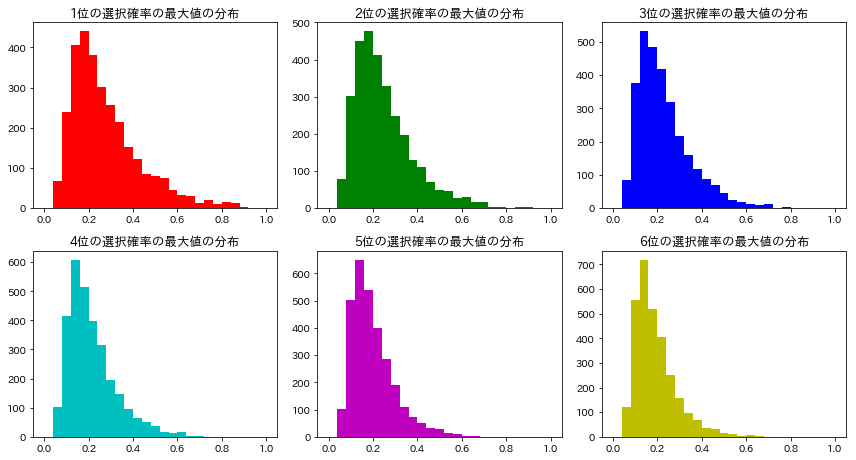

[2093  458 2680 1454 2924  989 2155  487 1701   76 1733  309 2326  898
   18  417   16 2401 2050 1332  894  133  338 2304 1641 2039 2416 1270
  200  901  209  433 1412 2141  437 1865 2396   32 1438  230  251 2193
 1071 2953 1181 1638   86  462  562 2031  684  519 2788 2797  727 1214
  551 1268   89  438   38 1539  437 2836 2599  988 2831 2702 2399 2058
  389 1269 1200  520  185  102   97 1811 1429   37 1877  898  193 2046
  395  256   55  125  720  939 1687   98 2839  286 1274 1186 1177  619
 1022 2109  172 1046  901  284  785 1617 2358 1612 2967 1069  112  584
  264 2165  300  151 1661   88 2264  909  816  139 1403 2895 2920  870
 1459  623 2398 2881  260 2474 2702  776 2353 2398 1741 1551 2811 1050
 2267  147  599  430  148  495  269  540 1122  271  557 2722   11 1157
   77  691   75 1030 1584  883  903 2234  297 2691 2059  726 2265 2890
  118  606  401 2157  488 1365 1432  945  806  330   59 2932 1510   80
  450  960 1479   64 2067  109 1110 1774 2700  981  264  307 1478  218
  802 

In [6]:
#生成したデータの集計と可視化
fig_range = np.append(np.array([0, 0, 0, 0, 0, 0]), np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])).reshape(2, 6)
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["1位の選択確率の最大値の分布", "2位の選択確率の最大値の分布", "3位の選択確率の最大値の分布",
         "4位の選択確率の最大値の分布", "5位の選択確率の最大値の分布", "6位の選択確率の最大値の分布"]
fig = plt.figure(figsize=(12.0, 6.5))
for j in range(len(legend)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(np.max(Prob_rank[rank_list[j], ], axis=1),  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

print(np.sum(y, axis=0))
print(np.round(np.sum(y, axis=0) / hhpt, 3))

In [7]:
####テストデータの生成####
##データの設定
shrink = 1.5
pt0 = np.random.poisson(Lambda/shrink, hh); pt[pt > member] = member
N0 = np.sum(pt0)
max_pt0 = np.max(pt0)

In [8]:
##idとインデックスの設定
#idの設定
user_id0 = np.repeat(np.arange(hh), pt0)
rank_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))
rank_pt0 = np.max(pt0)

#インデックスの設定
user_list0 = [i for i in range(hh)]
rank_list0 = [j for j in range(max_pt0)]
rank_n0 = np.repeat(0, max_pt0)
for i in range(hh):
    user_list0[i] = np.array(np.where(user_id0==i)[0], dtype="int")
for j in range(max_pt0):
    rank_list0[j] = np.array(np.where(rank_id0==j)[0], dtype="int")
    rank_n0[j] = rank_list0[j].shape[0] 

In [9]:
##応答変数の生成
#全パターンのロジットと応答確率を定義
logit0 = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
logit_exp0 = np.exp(logit0)
Prob0 = logit_exp0 / np.dot(logit_exp0, m_vec)[:, np.newaxis]

#多項分布からランクを生成
Prob_rank0 = np.zeros((N0, member), dtype="float32")
y0 = np.zeros((N0, member), dtype="int8")
Z0 = np.ones((N0, member), dtype="int8")
for j in range(max_pt0):
    if j==0:
        index = rank_list0[j]
        Prob_rank0[index, ] = Prob0.copy()
        y0[index, ] = np.array(rmnom(Prob_rank0[index, ], rank_n0[j], member, np.arange(rank_n0[j]), 1)[1].todense(), dtype="int8")
    else:
        index = rank_list0[j]
        Z0[index, ] = (1-y0[index-1, ]) * Z0[index-1, ]
        logit_rank = Z0[index, ] * np.exp(logit[user_id0[index], ])
        Prob_rank0[index, ] = logit_rank / np.dot(logit_rank, m_vec)[:, np.newaxis]
        y0[index, ] = np.array(rmnom(Prob_rank0[index, ], rank_n0[j], member, np.arange(rank_n0[j]), 1)[1].todense(), dtype="int8")

In [10]:
#####マルコフ連鎖モンテカルロ法でBayesian Rank Decompositionを推定####
##HMCでパラメータを推定するための関数
#対数事後分布の和を計算する関数
def Posterior(y, Z, logit, theta, alpha, inv_Cov, user_id, index, n, k, m_vec, pattern1, pattern2):
    #ロジットの対数尤度
    logit_exp = Z * np.exp(logit)[user_id, ] 
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]
    LLho = np.log(np.dot(y * Prob, m_vec))

    #多変量正規分布の対数事前分布
    er = theta - alpha   #パラメータの誤差
    if pattern1==1:
        LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))
    else:
        LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov), er)

    #対数事後分布の和
    if pattern2==1:
        LL = np.repeat(0.0, n)
        for i in range(n):
            LL[i] = np.sum(LLho[index[i], ]) + LLi_mvn[i]
    if pattern2==2:
        LL = np.sum(LLho[:, np.newaxis] * Z[:, :member-1], axis=0) + LLi_mvn
    else:
        LL = np.sum(LLho) + LLi_mvn
    return LL, LLho

In [11]:
#期待値パラメータの勾配を計算する関数
def dloglike(beta, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member):
    #応答確率の定義
    logit = np.append(beta, 0) + uv
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #勾配ベクトルの和を定義
    er_y = y - Prob; er = beta - alpha  
    dlogit = np.sum(er_y[:, :member-1], axis=0)
    dmvn = -np.dot(inv_Cov, er.T).T
    return -(dlogit + dmvn)

#リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [12]:
#ユーザー特徴ベクトルの勾配を計算する関数
def dloglike_u(theta_u, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec):
    #応答確率の定義
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #微分関数の設定
    er_y = y - Prob; er = theta_u - np.dot(u, alpha_u) 
    dlogit = np.dot(er_y, theta_v)
    dmvn = -np.dot(inv_Cov_u, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[user_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_u(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [13]:
#メンバー特徴ベクトルの勾配を計算する関数
def dloglike_v(theta_v, theta_u, theta_user, beta, alpha, inv_Cov_v, y, Z, user_id, member, k, m_vec):
    #応答確率の定義
    theta_v0 = np.vstack((theta_v, np.repeat(0, k)))
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v0.T)
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #微分関数の設定
    er_y = (y - Prob)[:, :member-1]; er = theta_v - alpha 
    dlogit = np.zeros((member-1, k))
    for j in range(k):
        dlogit[:, j] = np.sum(er_y * theta_user[:, j][:, np.newaxis], axis=0)
    dmvn = -np.dot(inv_Cov_v, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = dlogit + dmvn
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_v(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_u, theta_user, beta, alpha_v, inv_Cov_v, y, Z, user_id, member, k, m_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_u, theta_user, beta, alpha_v, inv_Cov_v, y, Z, user_id, member, k, m_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [14]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [15]:
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(100/keep)
iter = 0
disp = 10
e1 = 0.005
e2 = 0.025
e3 = 0.01
L1 = 3
L2 = 1

In [16]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
ADelta_u = np.diag(np.repeat(0.1, column))
Deltabar_u = np.full((column, k), 0.0)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s01 = 0.1
v01 = 0.1

#モデルパラメータの事前分布
alpha = np.repeat(0, member-1)
Cov = np.diag(np.repeat(100.0, member-1))
inv_Cov = np.linalg.inv(Cov)

In [17]:
##データとインデックスの設定
#階層モデルの定数
uu = np.dot(u.T, u)
inv_uu = np.linalg.inv(np.dot(u.T, u) + ADelta_u)

In [18]:
##パラメータの真値
#階層モデルのパラメータの真値
alpha_u =alphat_u.copy()
alpha_v = alphat_v.copy()
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
u_mu = np.dot(u, alpha_u)
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
beta = betat.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()

#期待値の定義
uv = np.dot(theta_u, theta_v.T)
logit = np.append(beta, 0) + uv

In [19]:
##パラメータの初期値
#階層モデルのパラメータの初期値
alpha_u = np.random.normal(0, 0.2, column*k).reshape(column, k)
alpha_v = np.repeat(0.0, k)
Cov_u = np.diag(np.repeat(1.0, k))
Cov_v = np.diag(np.repeat(1.0, k))
u_mu = np.dot(u, alpha_u)
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
beta = np.random.normal(0, 0.2, member-1)
theta_u = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k)), hh)
theta_v = np.vstack((np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k)), member-1), alpha_v))

#期待値の定義
uv = np.dot(theta_u, theta_v.T)
logit = np.append(beta, 0) + uv

In [20]:
##パラメータの格納用配列
ALPHA_U = np.zeros((column, k, int(R/keep)))
COV_U = np.zeros((k, k, int(R/keep)))
COV_V = np.zeros((k, k, int(R/keep)))
BETA = np.zeros((int(R/keep), member-1))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((member-1, k, int(R/keep)))

In [21]:
##対数尤度の基準値
#学習データに対する真値での対数尤度
mu = np.append(betat, 0) + np.dot(thetat_u, thetat_v.T)
LLbest = np.sum(Posterior(y, Z, mu, beta, alpha, inv_Cov, user_id, user_list, hh, k, m_vec, 0, 0)[1])
print(LLbest)

#テストデータに対する真値での対数尤度
mu = np.append(betat, 0) + np.dot(thetat_u, thetat_v.T)
LLbest0 = np.sum(Posterior(y0, Z0, mu, beta, alpha, inv_Cov, user_id0, user_list0, hh, k, m_vec, 0, 0)[1])
print(LLbest0)

-1180126.9582805934
-783593.591899754


In [ ]:
####ハミルトンモンテカルロ法でパラメータをサンプリング####
for rp in range(R):
    
    ##期待値パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, member-1)
    betad = beta.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, betad, dloglike, e1, L1)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    logit_new = np.append(betan, 0) + uv
    rev_new = np.dot(np.power(rnew, 2), m_vec[:member-1])/2
    rev_old = np.dot(np.power(rold, 2), m_vec[:member-1])/2
    Hnew = -Posterior(y, Z, logit_new, betan, alpha, inv_Cov, user_id, user_list, hh, k, m_vec, 0, 0)[0] + rev_new
    Hold = -Posterior(y, Z, logit, betad, alpha, inv_Cov, user_id, user_list, hh, k, m_vec, 0, 0)[0] + rev_old

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, 1)
    gamma = np.min(np.append(1, np.exp(Hold - Hnew)))
    gamma1 = gamma.copy()

    #gammaの値に基づき新しいbetaを採択
    flag = np.array((gamma > rand), dtype="int")
    beta = flag*betan + (1-flag)*betad
    if flag==1:
        logit = logit_new.copy()


    ##ユーザー特徴ベクトルをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1.0, k)), hh)
    thetad = theta_u.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog_u(rold, thetad, dloglike_u, e2, L1)
    rnew = res[0]
    thetan = res[1]

    #移動前と移動後のハミルトニアン
    logit_new = np.append(beta, 0) + np.dot(thetan, theta_v.T)
    rev_new = np.dot(np.power(rnew, 2), np.repeat(1, k))/2
    rev_old = np.dot(np.power(rold, 2), np.repeat(1, k))/2
    Hnew = -Posterior(y, Z, logit_new, thetan, u_mu, inv_Cov_u, user_id, user_list, hh, k, m_vec, 1, 1)[0] + rev_new
    Hold = -Posterior(y, Z, logit, thetad, u_mu, inv_Cov_u, user_id, user_list, hh, k, m_vec, 1, 1)[0] + rev_old

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    gamma = np.min(np.hstack((np.repeat(1, hh)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    gamma2 = gamma.copy()

    #gammaの値に基づき新しいユーザーパラメータを採択
    flag = np.array(gamma > rand, dtype="int")[:, np.newaxis]
    theta_u = flag*thetan + (1-flag)*thetad
    theta_user = theta_u[user_id, ]
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)


    ##メンバー特徴ベクトルをサンプリング
    #HMCの新しいパラメータを生成
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1.0, k)), member-1)
    thetad = theta_v[:member-1, ]

    #リープフロッグ法による1ステップ移動
    res = leapfrog_v(rold, thetad, dloglike_v, e3, L2)
    rnew = res[0]
    thetan = res[1]

    #移動前と移動後のハミルトニアン
    logit_new = np.append(beta, 0) + np.dot(theta_u, np.vstack((thetan, alpha_v)).T)
    Hnew = -Posterior(y, Z, logit_new, thetan, alpha_v, inv_Cov_v, user_id, user_list, hh, k, m_vec, 1, 2)[0]
    Hold = -Posterior(y, Z, logit, thetad, alpha_v, inv_Cov_v, user_id, user_list, hh, k, m_vec, 1, 2)[0] 

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, member-1)
    gamma = np.min(np.hstack((np.repeat(1, member-1)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    gamma3 = gamma.copy()

    #gammaの値に基づき新しいメンバーパラメータを採択
    flag = np.array(gamma > rand, dtype="int")[:, np.newaxis]
    theta_v = np.vstack((flag*thetan + (1-flag)*thetad, alpha_v))
    uv = np.dot(theta_u, theta_v.T)
    logit = np.append(beta, 0) + uv


    ##階層モデルのパラメータをサンプリング
    #多変量回帰モデルからユーザーパラメータをサンプリング
    out = rmultireg(theta_u, u, inv_uu, np.dot(u.T, theta_u), Cov_u, ADelta_u, Deltabar_u, V, nu, hh, column, k)
    alpha_u = out[0]
    Cov_u = np.diag(np.diag(out[1]))
    u_mu = np.dot(u, alpha_u)
    inv_Cov_u = np.linalg.inv(Cov_u)

    #逆ガンマ分布からメンバーパラメータの分散をサンプリング
    theta_v0 = theta_v[:member-1, ].reshape(-1)
    er = theta_v0 - np.mean(theta_v0)
    s1 = np.dot(er, er) + s01
    v1 = (member-1)*k + v01
    Cov_v = np.diag(np.repeat(1/np.random.gamma(v1/2, 1/(s1/2), 1), k))
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        ALPHA_U[:, :, mkeep] = alpha_u
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v
        BETA[mkeep, ] = beta
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v[:member-1, ]

    #対数尤度の更新とサンプリング結果の表示
    if rp%disp==0:
        #学習データに対する対数尤度を更新
        logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
        LL = np.sum(Posterior(y, Z, logit, beta, alpha, inv_Cov, user_id, user_list, hh, k, m_vec, 0, 0)[1])

        #テストデータに対する真値での対数尤度
        logit0 = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
        LL0 = np.sum(Posterior(y0, Z0, logit0, beta, alpha, inv_Cov, user_id0, user_list0, hh, k, m_vec, 0, 0)[1])

        #サンプリング結果の表示
        print(rp)
        print([np.round(np.mean(gamma1), 3), np.round(np.mean(gamma2), 3), np.round(np.mean(gamma3), 3)])
        print([np.round(LL, 1), np.round(LLbest, 1)])
        print([np.round(LL0, 1), np.round(LLbest0, 1)])

0
[1.0, 1.0, 1.0]
[-1555532.8, -1180127.0]
[-1059868.4, -783593.6]
10
[1.0, 1.0, 1.0]
[-1396233.1, -1180127.0]
[-939339.3, -783593.6]
20
[1.0, 1.0, 1.0]
[-1374954.6, -1180127.0]
[-924190.2, -783593.6]
30
[1.0, 1.0, 1.0]
[-1364871.7, -1180127.0]
[-916935.3, -783593.6]
40
[1.0, 1.0, 1.0]
[-1353284.8, -1180127.0]
[-908489.5, -783593.6]
50
[1.0, 1.0, 1.0]
[-1338564.1, -1180127.0]
[-897557.8, -783593.6]
60
[1.0, 1.0, 1.0]
[-1320550.1, -1180127.0]
[-884333.1, -783593.6]
